In [4]:
%pip install -qU "autogen-agentchat"
%pip install -qU  "autogen-ext[openai]"

# autogen-core 实现了一个模型客户端协议，
# 而 autogen-ext 实现了一组用于流行模型服务的模型客户端。 
# AgentChat 可以使用这些模型客户端与模型服务进行交互。

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# 日志模块
import logging

from autogen_core import EVENT_LOGGER_NAME

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(EVENT_LOGGER_NAME)
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO)


In [7]:
from autogen_ext.models.openai import OpenAIChatCompletionClient

openai_model_client = OpenAIChatCompletionClient(
    model="gpt-5-nano-2025-08-07",
    # api_key="sk-...", # Optional if you have an OPENAI_API_KEY environment variable set.
)

from autogen_core.models import UserMessage

result = await openai_model_client.create([UserMessage(content="What is the capital of France?", source="user")])
print(result)
await openai_model_client.close()


{"tools": [], "type": "LLMCall", "messages": [{"role": "user", "name": "user", "content": "What is the capital of France?"}], "response": {"id": "chatcmpl-CHnzeL4bCq2KRPkspWtlaMtKDhpAn", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "Paris.", "refusal": null, "role": "assistant", "annotations": [], "audio": null, "function_call": null, "tool_calls": null}}], "created": 1758359786, "model": "gpt-5-nano-2025-08-07", "object": "chat.completion", "service_tier": null, "system_fingerprint": null, "usage": {"completion_tokens": 76, "prompt_tokens": 14, "total_tokens": 90, "completion_tokens_details": {"accepted_prediction_tokens": 0, "audio_tokens": 0, "reasoning_tokens": 64, "rejected_prediction_tokens": 0}, "prompt_tokens_details": {"audio_tokens": 0, "cached_tokens": 0}}}, "prompt_tokens": 14, "completion_tokens": 76, "agent_id": null}
INFO:autogen_core.events:{"tools": [], "type": "LLMCall", "messages": [{"role": "user", "name": "user", "conte

finish_reason='stop' content='Paris.' usage=RequestUsage(prompt_tokens=14, completion_tokens=76) cached=False logprobs=None thought=None



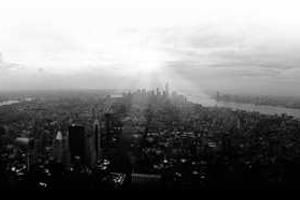

In [ ]:
# 在 AutoGen AgentChat 中，消息可以分为两种类型：代理-代理消息和代理的内部事件和消息。

# 1. 我们创建的 TextMessage 和 MultiModalMessage 可以通过 on_messages 方法直接传递给代理，
# 或者作为任务交给团队的 run() 方法。  

# 2. AgentChat 还支持 events 的概念 - 这些消息是代理内部的消息。 
# 这些消息用于传达代理内部操作的事件和信息，并且属于基类 BaseAgentEvent 的子类。

from autogen_agentchat.messages import TextMessage

# 文本消息
text_message = TextMessage(content="Hello, world!", source="User")


from io import BytesIO

import requests
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image as AGImage
from PIL import Image

pil_image = Image.open(BytesIO(requests.get("https://picsum.photos/300/200").content))
img = AGImage(pil_image)

# 多模态消息
multi_modal_message = MultiModalMessage(content=["Can you describe the content of this image?", img], source="User")
img


In [ ]:
# AutoGen AgentChat 提供了一组预设的代理，每个代理在如何响应消息方面都有所不同。
# 
# 所有代理都共享以下属性和方法
#   name：代理的唯一名称。
#   description：代理的文本描述。
#   run：该方法运行代理，给定一个字符串形式的任务或消息列表，并返回一个 TaskResult。 
#       **代理应该是状态化的，并且此方法应该用新的消息调用，而不是完整的历史记录**。
#   run_stream：与 run() 相同，但返回一个消息迭代器，这些消息是 BaseAgentEvent 或 BaseChatMessage 的子类，
#       随后是作为最后一项的 TaskResult。

# AssistantAgent 是一个内置代理，它使用语言模型并且具有使用工具的能力。
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import StructuredMessage
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient


# Define a tool that searches the web for information.
# For simplicity, we will use a mock function here that returns a static string.

# AssistantAgent 自动将 Python 函数转换为 FunctionTool，
# 该工具可以用作代理的工具，并自动从函数签名和文档字符串生成工具模式。
async def web_search(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."


# Create an agent that uses the OpenAI GPT-4o model.
model_client = OpenAIChatCompletionClient(
    model="gpt-5-nano-2025-08-07",
    # api_key="YOUR_API_KEY",
)
agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)

# 使用 run() 方法来获取在给定任务上运行的代理。
# Use asyncio.run(agent.run(...)) when running in a script.
result = await agent.run(task="Find information on AutoGen")
print(result.messages)



{"tools": [{"type": "function", "function": {"name": "web_search", "description": "Find information on the web", "parameters": {"type": "object", "properties": {"query": {"description": "query", "title": "Query", "type": "string"}}, "required": ["query"], "additionalProperties": false}, "strict": false}}], "type": "LLMCall", "messages": [{"content": "Use tools to solve tasks.", "role": "system"}, {"role": "user", "name": "user", "content": "Find information on AutoGen"}], "response": {"id": "chatcmpl-CHo5nKG28AXTEvFgyJJCX4rwhwHoT", "choices": [{"finish_reason": "tool_calls", "index": 0, "logprobs": null, "message": {"content": null, "refusal": null, "role": "assistant", "annotations": [], "audio": null, "function_call": null, "tool_calls": [{"id": "call_qFJNzb02qFJam6PByGyWT9JF", "function": {"arguments": "{\"query\": \"AutoGen\"}", "name": "web_search"}, "type": "function"}, {"id": "call_2GrpgHBfz9OCcuU2j88nLRVa", "function": {"arguments": "{\"query\": \"GNU Autogen\"}", "name": "web_

[TextMessage(id='49b58898-9960-4194-afec-7b7642b789f2', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 9, 20, 9, 22, 45, 212637, tzinfo=datetime.timezone.utc), content='Find information on AutoGen', type='TextMessage'), ToolCallRequestEvent(id='453692cc-a9a6-408b-804a-70b2446858e8', source='assistant', models_usage=RequestUsage(prompt_tokens=145, completion_tokens=714), metadata={}, created_at=datetime.datetime(2025, 9, 20, 9, 22, 49, 559143, tzinfo=datetime.timezone.utc), content=[FunctionCall(id='call_qFJNzb02qFJam6PByGyWT9JF', arguments='{"query": "AutoGen"}', name='web_search'), FunctionCall(id='call_2GrpgHBfz9OCcuU2j88nLRVa', arguments='{"query": "GNU Autogen"}', name='web_search'), FunctionCall(id='call_MsYZ6v9i5WYR63K5IZUrguiH', arguments='{"query": "Autogen tool Linux"}', name='web_search')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(id='6f4dd410-7a23-41bb-899b-246f55101fc2', source='assistant', models_usage=None, metadata={}, creat

In [12]:
# 流式输出消息
async def assistant_run_stream() -> None:
    # Option 1: read each message from the stream (as shown in the previous example).
    # async for message in agent.run_stream(task="Find information on AutoGen"):
    #     print(message)

    # Option 2: use Console to print all messages as they appear.
    await Console(
        agent.run_stream(task="Find information on AutoGen"),
        output_stats=True,  # Enable stats printing.
    )


# Use asyncio.run(assistant_run_stream()) when running in a script.
await assistant_run_stream()


---------- TextMessage (user) ----------
Find information on AutoGen


{"tools": [{"type": "function", "function": {"name": "web_search", "description": "Find information on the web", "parameters": {"type": "object", "properties": {"query": {"description": "query", "title": "Query", "type": "string"}}, "required": ["query"], "additionalProperties": false}, "strict": false}}], "type": "LLMCall", "messages": [{"content": "Use tools to solve tasks.", "role": "system"}, {"role": "user", "name": "user", "content": "Find information on AutoGen"}, {"role": "assistant", "tool_calls": [{"id": "call_qFJNzb02qFJam6PByGyWT9JF", "function": {"arguments": "{\"query\": \"AutoGen\"}", "name": "web_search"}, "type": "function"}, {"id": "call_2GrpgHBfz9OCcuU2j88nLRVa", "function": {"arguments": "{\"query\": \"GNU Autogen\"}", "name": "web_search"}, "type": "function"}, {"id": "call_MsYZ6v9i5WYR63K5IZUrguiH", "function": {"arguments": "{\"query\": \"Autogen tool Linux\"}", "name": "web_search"}, "type": "function"}], "content": null}, {"content": "AutoGen is a programming f

---------- ToolCallRequestEvent (assistant) ----------
[FunctionCall(id='call_964hj9XXwKCuDBByPomG0GwG', arguments='{"query": "AutoGen framework multi-agent"}', name='web_search'), FunctionCall(id='call_uXaALGGxawAAb6e548lQRPII', arguments='{"query": "Autogen GNU Autogen"}', name='web_search'), FunctionCall(id='call_AlWEOrD0kIeTYSfNNQHXFGJI', arguments='{"query": "AutoGen tool Linux multi-agent"}', name='web_search')]
[Prompt tokens: 275, Completion tokens: 337]


{"type": "ToolCall", "tool_name": "web_search", "arguments": {"query": "AutoGen framework multi-agent"}, "result": "AutoGen is a programming framework for building multi-agent applications.", "agent_id": null}
INFO:autogen_core.events:{"type": "ToolCall", "tool_name": "web_search", "arguments": {"query": "AutoGen framework multi-agent"}, "result": "AutoGen is a programming framework for building multi-agent applications.", "agent_id": null}
{"type": "ToolCall", "tool_name": "web_search", "arguments": {"query": "Autogen GNU Autogen"}, "result": "AutoGen is a programming framework for building multi-agent applications.", "agent_id": null}
INFO:autogen_core.events:{"type": "ToolCall", "tool_name": "web_search", "arguments": {"query": "Autogen GNU Autogen"}, "result": "AutoGen is a programming framework for building multi-agent applications.", "agent_id": null}
{"type": "ToolCall", "tool_name": "web_search", "arguments": {"query": "AutoGen tool Linux multi-agent"}, "result": "AutoGen is a 

---------- ToolCallExecutionEvent (assistant) ----------
[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', name='web_search', call_id='call_964hj9XXwKCuDBByPomG0GwG', is_error=False), FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', name='web_search', call_id='call_uXaALGGxawAAb6e548lQRPII', is_error=False), FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', name='web_search', call_id='call_AlWEOrD0kIeTYSfNNQHXFGJI', is_error=False)]
---------- ToolCallSummaryMessage (assistant) ----------
AutoGen is a programming framework for building multi-agent applications.
AutoGen is a programming framework for building multi-agent applications.
AutoGen is a programming framework for building multi-agent applications.
---------- Summary ----------
Number of messages: 4
Finish reason: None
Total prompt tokens: 275
Total co

| 步骤 | 阶段描述 | 对应消息类型 | 来源 | 说明 |
|------|----------|---------------|--------|------|
| 1 | 用户提出任务 | `TextMessage` | 用户 | 用户发起请求，例如："Find information on AutoGen" |
| 2 | 助手决定使用工具（思考） | `ToolCallRequestEvent` | Assistant | LLM 决定调用外部工具，并生成工具调用请求（如多个搜索查询） |
| 3 | 执行工具并获取结果 | `ToolCallExecutionEvent` | 系统 | 工具被实际执行（如调用 `web_search`），返回结果给代理 |
| 4 | 助手生成最终回答 | `ToolCallSummaryMessage` | Assistant | 基于工具执行结果，助手整合信息并生成自然语言回复 |


AssistantAgent 还可以使用从模型上下文协议 (MCP) 服务器提供的工具，通过使用 McpWorkbench() 实现。

```python
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_ext.tools.mcp import McpWorkbench, StdioServerParams

# Get the fetch tool from mcp-server-fetch.
fetch_mcp_server = StdioServerParams(command="uvx", args=["mcp-server-fetch"])

# Create an MCP workbench which provides a session to the mcp server.
async with McpWorkbench(fetch_mcp_server) as workbench:  # type: ignore
    # Create an agent that can use the fetch tool.
    model_client = OpenAIChatCompletionClient(model="gpt-4.1-nano")
    fetch_agent = AssistantAgent(
        name="fetcher", model_client=model_client, workbench=workbench, reflect_on_tool_use=True
    )

    # Let the agent fetch the content of a URL and summarize it.
    result = await fetch_agent.run(task="Summarize the content of https://en.wikipedia.org/wiki/Seattle")
    assert isinstance(result.messages[-1], TextMessage)
    print(result.messages[-1].content)

    # Close the connection to the model client.
    await model_client.close()
```

## 团队是一组协同工作以实现共同目标的代理。

**AgentChat 支持几种团队预设**

- RoundRobinGroupChat：一个团队以循环方式运行群聊，参与者轮流发言
- SelectorGroupChat：一个团队在每条消息后使用 ChatCompletion 模型选择下一个发言人。
- MagenticOneGroupChat：一种通用的多代理系统，用于解决跨各种领域的开放式 Web 和基于文件的任务。
- Swarm：一个团队使用 HandoffMessage 来表示代理之间的转换。

首先创建一个具有两个 AssistantAgent 和一个 TextMentionTermination 条件的团队，

当在代理的响应中检测到特定单词时，该条件会停止团队。

这个双代理团队实现了反射模式，这是一种多代理设计模式，其中评论员代理评估主要代理的响应。

In [ ]:
import asyncio

# 导入核心组件：AssistantAgent 是具备语言模型和工具调用能力的智能体
from autogen_agentchat.agents import AssistantAgent

# TaskResult 表示任务执行的结果对象
from autogen_agentchat.base import TaskResult

# 导入终止条件模块
# - ExternalTermination: 外部控制的终止（如手动停止）
# - TextMentionTermination: 当某条消息中包含特定文本时自动终止
from autogen_agentchat.conditions import ExternalTermination, TextMentionTermination

# RoundRobinGroupChat：轮询式小组讨论团队，多个 agent 按顺序轮流发言
from autogen_agentchat.teams import RoundRobinGroupChat

# Console：用于在终端流式输出聊天内容（可选，用于可视化）
from autogen_agentchat.ui import Console

# CancellationToken：允许外部取消异步任务（例如用户中途取消）
from autogen_core import CancellationToken

# 使用 OpenAI 的模型客户端（封装了 gpt-5-nano 等模型调用）
from autogen_ext.models.openai import OpenAIChatCompletionClient


# 创建一个连接到 OpenAI 模型的客户端
model_client = OpenAIChatCompletionClient(
    model="gpt-5-nano-2025-08-07",  # 指定使用的模型名称
    # api_key="sk-...",           # 可选：显式提供 API 密钥
    # 如果未指定，会自动读取环境变量 OPENAI_API_KEY
)

# 创建“主创”智能体（负责生成初始内容）
primary_agent = AssistantAgent(
    name="primary",                   # 智能体的名字，在对话中标识身份
    model_client=model_client,       # 使用哪个 LLM 客户端进行推理
    system_message="You are a helpful AI assistant.",  # 系统提示词，定义其行为角色
)

# 创建“评论家”智能体（负责审查和反馈）
critic_agent = AssistantAgent(
    name="critic",                    # 名字为 critic
    model_client=model_client,
    system_message="Provide constructive feedback. Respond with 'APPROVE' when your feedbacks are addressed.",
    # 提示它要给出建设性意见，并在满意时回复 'APPROVE'
)

# 定义一个终止条件：当任意消息中出现 "APPROVE" 字样时，结束整个流程
text_termination = TextMentionTermination("APPROVE")

# 创建一个“轮询式小组讨论”团队
# - 成员包括 primary_agent 和 critic_agent
# - 他们会按顺序轮流发言（round-robin），直到满足终止条件
team = RoundRobinGroupChat(
    agents=[primary_agent, critic_agent],         # 团队成员列表
    termination_condition=text_termination        # 终止条件：检测到 APPROVE 就停
)

# 补充说明：为何叫“轮询”？
# 即使只有两个 agent，也遵循顺序：

# primary → 写诗
# critic → 审核
# （如果没结束）→ primary 修改 → critic 再审...
# 但由于 APPROVE 出现在第一次 critic 回复中，所以只进行了 一轮完整交互 就结束了。
# 可扩展为更复杂的多代理工作流（写作 → 审核 → 修改 → 再审 → 发布）


# 开始运行团队协作任务
# 注意：在脚本中应使用 asyncio.run(team.run(...))
result = await team.run(task="Write a short poem about the fall season.")
# 执行任务：“写一首关于秋天的短诗”

# 输出最终结果
print(result)

{"payload": "{\"messages\":[{\"id\":\"1dc0b3ad-9c60-4edb-92a2-2c4a54ce515b\",\"source\":\"user\",\"models_usage\":null,\"metadata\":{},\"created_at\":\"2025-09-20T09:49:58.568270Z\",\"content\":\"Write a short poem about the fall season.\",\"type\":\"TextMessage\"}],\"output_task_messages\":true}", "sender": null, "receiver": "RoundRobinGroupChatManager_515fd86a-beb3-4aff-a765-24efa806638f/515fd86a-beb3-4aff-a765-24efa806638f", "kind": "MessageKind.DIRECT", "delivery_stage": "DeliveryStage.SEND", "type": "Message"}
INFO:autogen_core.events:{"payload": "{\"messages\":[{\"id\":\"1dc0b3ad-9c60-4edb-92a2-2c4a54ce515b\",\"source\":\"user\",\"models_usage\":null,\"metadata\":{},\"created_at\":\"2025-09-20T09:49:58.568270Z\",\"content\":\"Write a short poem about the fall season.\",\"type\":\"TextMessage\"}],\"output_task_messages\":true}", "sender": null, "receiver": "RoundRobinGroupChatManager_515fd86a-beb3-4aff-a765-24efa806638f/515fd86a-beb3-4aff-a765-24efa806638f", "kind": "MessageKind.D

messages=[TextMessage(id='1dc0b3ad-9c60-4edb-92a2-2c4a54ce515b', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 9, 20, 9, 49, 58, 568270, tzinfo=datetime.timezone.utc), content='Write a short poem about the fall season.', type='TextMessage'), TextMessage(id='11f0ffd5-87c6-41f8-a53f-a03f8649e2ca', source='primary', models_usage=RequestUsage(prompt_tokens=27, completion_tokens=1743), metadata={}, created_at=datetime.datetime(2025, 9, 20, 9, 50, 8, 78141, tzinfo=datetime.timezone.utc), content='Autumn slips in with copper light,\nthe air grows crisp and bright with dusk.\nLeaves loosen from green to ember-bright,\ndrifting like gold on a sleepy gust.\n\nA kettle sighs with cinnamon steam,\npumpkins grin on the doorstep glow.\nGeese trace quiet lines across the stream,\nand night comes soft where warm fires grow.', type='TextMessage'), TextMessage(id='353179ef-134f-4ee5-a4f0-68da2682d6b8', source='critic', models_usage=RequestUsage(prompt_tokens=114, comp

In [ ]:
# 重置团队。 
# 此方法将清除团队的状态，包括所有代理。 它将调用每个代理的 on_reset() 方法来清除代理的状态。
await team.reset()  # Reset the team for a new task.
await Console(team.run_stream(task="Write a short poem about the fall season."))  # Stream the messages to the console.


{"payload": "{}", "sender": null, "receiver": "primary_515fd86a-beb3-4aff-a765-24efa806638f/515fd86a-beb3-4aff-a765-24efa806638f", "kind": "MessageKind.DIRECT", "delivery_stage": "DeliveryStage.SEND", "type": "Message"}
INFO:autogen_core.events:{"payload": "{}", "sender": null, "receiver": "primary_515fd86a-beb3-4aff-a765-24efa806638f/515fd86a-beb3-4aff-a765-24efa806638f", "kind": "MessageKind.DIRECT", "delivery_stage": "DeliveryStage.SEND", "type": "Message"}
{"payload": "{}", "sender": null, "receiver": "primary_515fd86a-beb3-4aff-a765-24efa806638f/515fd86a-beb3-4aff-a765-24efa806638f", "kind": "MessageKind.DIRECT", "delivery_stage": "DeliveryStage.DELIVER", "type": "Message"}
INFO:autogen_core.events:{"payload": "{}", "sender": null, "receiver": "primary_515fd86a-beb3-4aff-a765-24efa806638f/515fd86a-beb3-4aff-a765-24efa806638f", "kind": "MessageKind.DIRECT", "delivery_stage": "DeliveryStage.DELIVER", "type": "Message"}
{"payload": "Message could not be serialized", "sender": "primar

---------- TextMessage (user) ----------
Write a short poem about the fall season.


{"tools": [], "type": "LLMCall", "messages": [{"content": "You are a helpful AI assistant.", "role": "system"}, {"role": "user", "name": "user", "content": "Write a short poem about the fall season."}], "response": {"id": "chatcmpl-CHoc1wpUeOcVghivW9c8R0otVIaPJ", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "Autumn slips in with a copper sigh,\ncrisp air curling under a sapphire sky.\nLeaves flare to gold, to russet, to flame,\nPumpkins grin by the fence and lane.\nSweaters hug the shoulders, cider warms the hand,\nLanterns glow where shadows learn to stand.\nFields bend low to harvest's patient call,\nand fall, with quiet fire, covers all.", "refusal": null, "role": "assistant", "annotations": [], "audio": null, "function_call": null, "tool_calls": null}}], "created": 1758362165, "model": "gpt-5-nano-2025-08-07", "object": "chat.completion", "service_tier": null, "system_fingerprint": null, "usage": {"completion_tokens": 1369, "prompt_toke

---------- TextMessage (primary) ----------


INFO:autogen_core.events:{"payload": "{}", "sender": "RoundRobinGroupChatManager_515fd86a-beb3-4aff-a765-24efa806638f/515fd86a-beb3-4aff-a765-24efa806638f", "receiver": "critic_515fd86a-beb3-4aff-a765-24efa806638f/515fd86a-beb3-4aff-a765-24efa806638f", "kind": "MessageKind.PUBLISH", "delivery_stage": "DeliveryStage.SEND", "type": "Message"}
{"payload": "{}", "sender": "RoundRobinGroupChatManager_515fd86a-beb3-4aff-a765-24efa806638f/515fd86a-beb3-4aff-a765-24efa806638f", "receiver": null, "kind": "MessageKind.PUBLISH", "delivery_stage": "DeliveryStage.DELIVER", "type": "Message"}
INFO:autogen_core.events:{"payload": "{}", "sender": "RoundRobinGroupChatManager_515fd86a-beb3-4aff-a765-24efa806638f/515fd86a-beb3-4aff-a765-24efa806638f", "receiver": null, "kind": "MessageKind.PUBLISH", "delivery_stage": "DeliveryStage.DELIVER", "type": "Message"}


Autumn slips in with a copper sigh,
crisp air curling under a sapphire sky.
Leaves flare to gold, to russet, to flame,
Pumpkins grin by the fence and lane.
Sweaters hug the shoulders, cider warms the hand,
Lanterns glow where shadows learn to stand.
Fields bend low to harvest's patient call,
and fall, with quiet fire, covers all.


{"tools": [], "type": "LLMCall", "messages": [{"content": "Provide constructive feedback. Respond with 'APPROVE' to when your feedbacks are addressed.", "role": "system"}, {"role": "user", "name": "user", "content": "Write a short poem about the fall season."}, {"role": "user", "name": "primary", "content": "Autumn slips in with a copper sigh,\ncrisp air curling under a sapphire sky.\nLeaves flare to gold, to russet, to flame,\nPumpkins grin by the fence and lane.\nSweaters hug the shoulders, cider warms the hand,\nLanterns glow where shadows learn to stand.\nFields bend low to harvest's patient call,\nand fall, with quiet fire, covers all."}], "response": {"id": "chatcmpl-CHoc8QXh6jZunwAQzW1fJNmTtYUAt", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "Nice work. Your poem sits warmly in the autumn mood and uses vivid color imagery and gentle cadence. Here are some constructive notes to refine it further.\n\nWhat works well\n- Evocative imager

---------- TextMessage (critic) ----------
Nice work. Your poem sits warmly in the autumn mood and uses vivid color imagery and gentle cadence. Here are some constructive notes to refine it further.

What works well
- Evocative imagery: copper sigh, sapphire sky, leaves turning gold and russet, pumpkins, cider, lanterns. The color palette feels distinctly autumnal.
- Sensory layering: sight (colors), touch (sweaters, cider), and a hint of sound (lanterns, shadows) create a cozy atmosphere.
- Mood and tone: it has a quiet, reflective warmth that fits fall beautifully.
- Sound devices: the rhyme pairs (sigh/sky, flame/lane, hand/stand, call/all) give the poem a familiar, singable rhythm.

Suggestions for refinement
- Meter and cadence: some lines feel longer or shorter than others, which can interrupt the flow. A tighter or more regular meter will heighten the musicality.
  - Example: aim for roughly the same syllable count per line or a consistent beat pattern.
- Line endings and word c

TaskResult(messages=[TextMessage(id='9cede8ed-8163-4fc2-b882-5c400dab14f3', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 9, 20, 9, 56, 2, 902307, tzinfo=datetime.timezone.utc), content='Write a short poem about the fall season.', type='TextMessage'), TextMessage(id='5d3cfec9-7b73-4dd2-b121-e8da9dc0620f', source='primary', models_usage=RequestUsage(prompt_tokens=27, completion_tokens=1369), metadata={}, created_at=datetime.datetime(2025, 9, 20, 9, 56, 9, 949957, tzinfo=datetime.timezone.utc), content="Autumn slips in with a copper sigh,\ncrisp air curling under a sapphire sky.\nLeaves flare to gold, to russet, to flame,\nPumpkins grin by the fence and lane.\nSweaters hug the shoulders, cider warms the hand,\nLanterns glow where shadows learn to stand.\nFields bend low to harvest's patient call,\nand fall, with quiet fire, covers all.", type='TextMessage'), TextMessage(id='d99a7964-1d78-4cbb-b027-a77b224d6b54', source='critic', models_usage=RequestUsa

![image.png](https://msdocs.cn/autogen/stable/_images/human-in-the-loop-user-proxy.svg)

In [ ]:
# 人机协作

from autogen_agentchat.agents import AssistantAgent, UserProxyAgent
from autogen_agentchat.conditions import TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

# Create the agents.
model_client = OpenAIChatCompletionClient(model="gpt-5-nano-2025-08-07")
assistant = AssistantAgent("assistant", model_client=model_client)
user_proxy = UserProxyAgent("user_proxy", input_func=input)  # Use input() to get user input from console.

# Create the termination condition which will end the conversation when the user says "APPROVE".
termination = TextMentionTermination("APPROVE")

# Create the team.
team = RoundRobinGroupChat([assistant, user_proxy], termination_condition=termination, max_turns=10)

# Run the conversation and stream to the console.
stream = team.run_stream(task="Write a 4-line poem about the ocean.")
# Use asyncio.run(...) when running in a script.
await Console(stream)
await model_client.close()



# 支持 websocket
# @app.websocket("/ws/chat")
# async def chat(websocket: WebSocket):
#     await websocket.accept()

#     async def _user_input(prompt: str, cancellation_token: CancellationToken | None) -> str:
#         data = await websocket.receive_json() # Wait for user message from websocket.
#         message = TextMessage.model_validate(data) # Assume user message is a TextMessage.
#         return message.content
    
#     # Create user proxy with custom input function
#     # Run the team with the user proxy
#     # ...


{"payload": "{\"messages\":[{\"id\":\"37739701-7919-4ffb-abbf-c44717d488f4\",\"source\":\"user\",\"models_usage\":null,\"metadata\":{},\"created_at\":\"2025-09-20T10:03:19.829313Z\",\"content\":\"Write a 4-line poem about the ocean.\",\"type\":\"TextMessage\"}],\"output_task_messages\":true}", "sender": null, "receiver": "RoundRobinGroupChatManager_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "kind": "MessageKind.DIRECT", "delivery_stage": "DeliveryStage.SEND", "type": "Message"}
INFO:autogen_core.events:{"payload": "{\"messages\":[{\"id\":\"37739701-7919-4ffb-abbf-c44717d488f4\",\"source\":\"user\",\"models_usage\":null,\"metadata\":{},\"created_at\":\"2025-09-20T10:03:19.829313Z\",\"content\":\"Write a 4-line poem about the ocean.\",\"type\":\"TextMessage\"}],\"output_task_messages\":true}", "sender": null, "receiver": "RoundRobinGroupChatManager_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "kind": "MessageKind.DIRECT", "d

---------- TextMessage (user) ----------
Write a 4-line poem about the ocean.


{"tools": [], "type": "LLMCall", "messages": [{"content": "You are a helpful AI assistant. Solve tasks using your tools. Reply with TERMINATE when the task has been completed.", "role": "system"}, {"role": "user", "name": "user", "content": "Write a 4-line poem about the ocean."}], "response": {"id": "chatcmpl-CHoj4kRQnl3099GTcqpxReaOL54CO", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "The ocean breathes in silver on the shore.\nIts waves keep time with a patient roar.\nBeneath the foam, a quiet depth hums low.\nThe horizon widens where dreams learn to soar.\nTERMINATE", "refusal": null, "role": "assistant", "annotations": [], "audio": null, "function_call": null, "tool_calls": null}}], "created": 1758362602, "model": "gpt-5-nano-2025-08-07", "object": "chat.completion", "service_tier": null, "system_fingerprint": null, "usage": {"completion_tokens": 567, "prompt_tokens": 45, "total_tokens": 612, "completion_tokens_details": {"accepted_pre

---------- TextMessage (assistant) ----------


{"payload": "{}", "sender": "RoundRobinGroupChatManager_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "receiver": "user_proxy_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "kind": "MessageKind.PUBLISH", "delivery_stage": "DeliveryStage.SEND", "type": "Message"}
INFO:autogen_core.events:{"payload": "{}", "sender": "RoundRobinGroupChatManager_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "receiver": "user_proxy_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "kind": "MessageKind.PUBLISH", "delivery_stage": "DeliveryStage.SEND", "type": "Message"}
{"payload": "{}", "sender": "RoundRobinGroupChatManager_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "receiver": null, "kind": "MessageKind.PUBLISH", "delivery_stage": "DeliveryStage.DELIVER", "type": "Message"}
INFO:autogen_core.events:{"payload": "{}", "sender": "RoundRobinGroupChatManager_86d68a0

The ocean breathes in silver on the shore.
Its waves keep time with a patient roar.
Beneath the foam, a quiet depth hums low.
The horizon widens where dreams learn to soar.
TERMINATE


{"payload": "{\"message\":{\"id\":\"95ed9d04-fd8a-498e-be6a-3ae992000f27\",\"source\":\"user_proxy\",\"models_usage\":null,\"metadata\":{},\"created_at\":\"2025-09-20T10:03:24.332401Z\",\"request_id\":\"4745f430-e16f-480b-9b7d-e1e325abe9f7\",\"content\":\"\",\"type\":\"UserInputRequestedEvent\"}}", "sender": "user_proxy_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "receiver": "output_topic_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "kind": "MessageKind.PUBLISH", "delivery_stage": "DeliveryStage.SEND", "type": "Message"}
INFO:autogen_core.events:{"payload": "{\"message\":{\"id\":\"95ed9d04-fd8a-498e-be6a-3ae992000f27\",\"source\":\"user_proxy\",\"models_usage\":null,\"metadata\":{},\"created_at\":\"2025-09-20T10:03:24.332401Z\",\"request_id\":\"4745f430-e16f-480b-9b7d-e1e325abe9f7\",\"content\":\"\",\"type\":\"UserInputRequestedEvent\"}}", "sender": "user_proxy_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-35

---------- TextMessage (user_proxy) ----------


INFO:autogen_core.events:{"payload": "{}", "sender": "RoundRobinGroupChatManager_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "receiver": "assistant_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "kind": "MessageKind.PUBLISH", "delivery_stage": "DeliveryStage.SEND", "type": "Message"}
{"payload": "{}", "sender": "RoundRobinGroupChatManager_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "receiver": null, "kind": "MessageKind.PUBLISH", "delivery_stage": "DeliveryStage.DELIVER", "type": "Message"}


no


INFO:autogen_core.events:{"payload": "{}", "sender": "RoundRobinGroupChatManager_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "receiver": null, "kind": "MessageKind.PUBLISH", "delivery_stage": "DeliveryStage.DELIVER", "type": "Message"}
{"tools": [], "type": "LLMCall", "messages": [{"content": "You are a helpful AI assistant. Solve tasks using your tools. Reply with TERMINATE when the task has been completed.", "role": "system"}, {"role": "user", "name": "user", "content": "Write a 4-line poem about the ocean."}, {"role": "assistant", "content": "The ocean breathes in silver on the shore.\nIts waves keep time with a patient roar.\nBeneath the foam, a quiet depth hums low.\nThe horizon widens where dreams learn to soar.\nTERMINATE"}, {"role": "user", "name": "user_proxy", "content": "no"}], "response": {"id": "chatcmpl-CHojpkYLc0UM5ZHDRUVc11FJ3F2j4", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "TERMINATE", "re

---------- TextMessage (assistant) ----------


{"payload": "{}", "sender": "RoundRobinGroupChatManager_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "receiver": "user_proxy_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "kind": "MessageKind.PUBLISH", "delivery_stage": "DeliveryStage.SEND", "type": "Message"}
INFO:autogen_core.events:{"payload": "{}", "sender": "RoundRobinGroupChatManager_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "receiver": "user_proxy_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "kind": "MessageKind.PUBLISH", "delivery_stage": "DeliveryStage.SEND", "type": "Message"}
{"payload": "{}", "sender": "RoundRobinGroupChatManager_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "receiver": null, "kind": "MessageKind.PUBLISH", "delivery_stage": "DeliveryStage.DELIVER", "type": "Message"}


TERMINATE


INFO:autogen_core.events:{"payload": "{}", "sender": "RoundRobinGroupChatManager_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "receiver": null, "kind": "MessageKind.PUBLISH", "delivery_stage": "DeliveryStage.DELIVER", "type": "Message"}
{"payload": "{\"message\":{\"id\":\"04f02c4d-70f7-4b1f-8d37-5a806356e24c\",\"source\":\"user_proxy\",\"models_usage\":null,\"metadata\":{},\"created_at\":\"2025-09-20T10:04:10.692882Z\",\"request_id\":\"4a62da5f-44a5-4881-b207-6ba389946e5c\",\"content\":\"\",\"type\":\"UserInputRequestedEvent\"}}", "sender": "user_proxy_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "receiver": "output_topic_86d68a09-e25f-4ec6-beb6-3559dac78d70/86d68a09-e25f-4ec6-beb6-3559dac78d70", "kind": "MessageKind.PUBLISH", "delivery_stage": "DeliveryStage.SEND", "type": "Message"}
INFO:autogen_core.events:{"payload": "{\"message\":{\"id\":\"04f02c4d-70f7-4b1f-8d37-5a806356e24c\",\"source\":\"user_proxy\",\"models_usage\"

---------- TextMessage (user_proxy) ----------
APPROVE


In [2]:
# Swarm 实现了一个团队，其中代理可以根据其能力将任务交给其他代理。
# 这是一种多代理设计模式，最初由 OpenAI 在 Swarm 中引入。 
# 核心思想是让代理使用特殊的工具调用将任务委派给其他代理，同时所有代理共享相同的消息上下文。 
# 这使代理能够对任务计划做出本地决策，而不是像 SelectorGroupChat 中那样依赖于中央协调器。

# 工作原理
# Swarm 团队是一个群聊，代理轮流生成响应。 
# 与 SelectorGroupChat 和 RoundRobinGroupChat 类似，参与代理会广播他们的响应，以便所有代理共享相同的消息上下文。

# 与其他两个群聊团队不同，在每次轮换时，发言代理是根据上下文中最新的 HandoffMessage 消息选择的。 
# 这自然要求团队中的每个代理都能够生成 HandoffMessage 来表明它将移交给哪些其他代理。

# 对于 AssistantAgent，您可以设置 handoffs 参数来指定它可以移交给哪些代理。 
# 您可以使用 Handoff 来自定义消息内容和移交行为。


# 去中心化的任务流转
# 传统的多代理系统通常依赖一个“中央指挥官”（如规划员）来决定下一步该由谁执行。而 Swarm 模式的精髓在于去中心化和自主决策。

# 传统方式 (如 SelectorGroupChat): 有一个主协调器不断询问：“现在轮到谁了？” 它根据预设规则或投票来选择下一个说话的代理。
# Swarm 方式: 每个代理在完成自己的工作后，会主动说：“这件事我做完了，接下来应该交给 flights_refunder 处理。” 或者 “我需要用户告诉我航班号，所以现在把任务交给 user。” 下一个发言者是由当前发言者通过生成一个特殊的 HandoffMessage 来指定的。
# 这就像一个高效的团队会议：不是由主持人点名让每个人发言，而是每个成员在讲完自己的部分后，自然地把话筒递给下一个需要发言的人。

# 工作流程
# 1 旅行社代理发起对话并评估用户的请求。
# 2 根据请求
# 2.1 对于与退款相关的任务，旅行社代理会移交给航班退款员。
# 2.2 对于需要从客户处获取的信息，任何一个代理都可以移交给 "user"。
# 3 航班退款员在适当的时候使用 refund_flight 工具处理退款。
# 4 如果代理移交给 "user"，团队执行将停止并等待用户输入响应。
# 5 当用户提供输入时，它将作为 HandoffMessage 发送回团队。 此消息定向到最初请求用户输入的代理。
# 6 该过程将继续，直到旅行社代理确定任务已完成并终止工作流程。
# -*- coding: utf-8 -*-
"""
AutoGen Swarm 示例：客户支持团队（航班退款）
本示例展示了如何使用 Swarm 模式创建一个包含人机协作的多代理系统。
"""

# 导入类型提示所需的模块
from typing import Any, Dict, List

# 从 AutoGen 库中导入核心组件
from autogen_agentchat.agents import AssistantAgent          # 助理智能体类
from autogen_agentchat.conditions import HandoffTermination, TextMentionTermination  # 终止条件
from autogen_agentchat.messages import HandoffMessage        # 移交通知消息类
from autogen_agentchat.teams import Swarm                    # Swarm 团队类
from autogen_agentchat.ui import Console                     # 控制台输出工具
from autogen_ext.models.openai import OpenAIChatCompletionClient  # OpenAI 模型客户端

def refund_flight(flight_id: str) -> str:
    """
    模拟执行航班退款操作的工具函数。
    在真实场景中，此函数会调用航空公司或票务系统的API。
    
    Args:
        flight_id (str): 需要退款的航班ID。
        
    Returns:
        str: 退款操作的结果信息。
    """
    return f"航班 {flight_id} 已成功退款"

# 配置用于所有智能体的大语言模型客户端
model_client = OpenAIChatCompletionClient(
    model="gpt-4o",  # 使用的模型名称
    # api_key="YOUR_API_KEY",       # 此处应填入您的实际API密钥
    parallel_tool_calls=False  # 禁用并行工具调用，防止产生多个移交导致意外行为 [[1]]
)

# 创建旅行社代理
travel_agent = AssistantAgent(
    "travel_agent",                 # 代理的唯一名称
    model_client=model_client,      # 使用的模型客户端
    handoffs=["flights_refunder", "user"],  # 定义该代理可以将任务移交给哪些目标
    system_message="""
你是一位专业的旅行顾问。
你的主要职责是接待客户并初步评估他们的请求。
- 如果客户的请求涉及航班退款，请将任务移交给专门处理此事的 'flights_refunder'。
- 如果你需要向客户获取更多信息（例如行程细节），你必须先在消息中清楚地提出你的问题，然后才能将任务移交给 'user'。
- 当你确认所有事项都已妥善处理完毕后，请输出 'TERMINATE' 来结束本次服务流程。"""
)

# 创建航班退款员代理
flights_refunder = AssistantAgent(
    "flights_refunder",             # 代理的唯一名称
    model_client=model_client,      # 使用的模型客户端
    handoffs=["travel_agent", "user"],  # 定义该代理可以将任务移交给哪些目标
    tools=[refund_flight],          # 为该代理提供可调用的工具列表
    system_message="""
你是一位专注于处理航班退款的专家代理。
你的工作是高效、准确地完成退款操作。
- 你只需要客户提供航班参考号即可启动退款流程。
- 你可以使用 'refund_flight' 工具来执行实际的退款操作。
- 如果缺少关键信息（如航班号），你必须先发送一条消息说明你需要什么信息，然后将任务移交给 'user' 以等待回复。
- 当你成功完成退款交易后，请将控制权交还给 'travel_agent'，由其进行最终确认并向客户通报结果。"""
)

# 定义团队的终止条件。满足任一条件时，团队停止运行。
termination = (
    HandoffTermination(target="user") |     # 当任务被移交给 "user" 时，流程暂停，等待用户输入
    TextMentionTermination("TERMINATE")     # 当任何消息中包含 "TERMINATE" 字样时，流程完全结束
)

# 创建 Swarm 团队，将两个代理组织起来，并指定终止条件。
# 所有代理共享相同的消息上下文，发言顺序由最新的 HandoffMessage 决定。
team = Swarm([travel_agent, flights_refunder], termination_condition=termination)

# 用户发起的初始任务请求
task = "我需要退掉我的航班。"

async def run_team_stream() -> None:
    """
    运行团队并处理与用户的交互循环。
    该函数处理自动化流程与人工输入之间的切换。
    """
    # 启动团队处理初始任务，并将对话流实时输出到控制台
    task_result = await Console(team.run_stream(task=task))
    # 获取团队返回的最后一条消息
    last_message = task_result.messages[-1]

    # 循环检查：如果最后一条消息是发给 "user" 的 HandoffMessage，则需要用户输入
    while isinstance(last_message, HandoffMessage) and last_message.target == "user":
        # 等待用户在命令行中输入回复
        user_message = input("用户: ")
        
        # 将用户的回复包装成一个新的 HandoffMessage，其目标是之前请求信息的代理
        # 并将此消息作为新任务提交给团队继续执行
        task_result = await Console(
            team.run_stream(task=HandoffMessage(source="user", target=last_message.source, content=user_message))
        )
        # 更新最后一条消息，检查是否需要再次等待用户输入（例如，提供了错误的航班号）
        last_message = task_result.messages[-1]

# 使用 asyncio.run(...) 如果你在脚本中运行此代码
await run_team_stream()

# 关闭模型客户端连接，释放资源
await model_client.close()


---------- TextMessage (user) ----------
我需要退掉我的航班。
---------- ToolCallRequestEvent (travel_agent) ----------
[FunctionCall(id='call_sYbt3VDfOKBVDdGvgczUdKPY', arguments='{}', name='transfer_to_flights_refunder')]
---------- ToolCallExecutionEvent (travel_agent) ----------
[FunctionExecutionResult(content='Transferred to flights_refunder, adopting the role of flights_refunder immediately.', name='transfer_to_flights_refunder', call_id='call_sYbt3VDfOKBVDdGvgczUdKPY', is_error=False)]
---------- HandoffMessage (travel_agent) ----------
Transferred to flights_refunder, adopting the role of flights_refunder immediately.
---------- TextMessage (flights_refunder) ----------
请提供您的航班参考号，以便我启动退款流程。
---------- ToolCallRequestEvent (flights_refunder) ----------
[FunctionCall(id='call_XXOJq6Pcv1S3TqzAkKc5Pp6E', arguments='{}', name='transfer_to_user')]
---------- ToolCallExecutionEvent (flights_refunder) ----------
[FunctionExecutionResult(content='Transferred to user, adopting the role of user i

## 工作流方式

```python
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.teams import DiGraphBuilder, GraphFlow
from autogen_ext.models.openai import OpenAIChatCompletionClient

# Create an OpenAI model client
client = OpenAIChatCompletionClient(model="gpt-4.1-nano")

# Create the writer agent
writer = AssistantAgent("writer", model_client=client, system_message="Draft a short paragraph on climate change.")

# Create the reviewer agent
reviewer = AssistantAgent("reviewer", model_client=client, system_message="Review the draft and suggest improvements.")

# Build the graph
builder = DiGraphBuilder()
builder.add_node(writer).add_node(reviewer)
builder.add_edge(writer, reviewer)

# Build and validate the graph
graph = builder.build()

# Create the flow
flow = GraphFlow([writer, reviewer], graph=graph)
```